In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax.config import config
config.update("jax_enable_x64", True)

Specify initial setup of the signal, by first loading parameters from the stochastic traveling wave.

In [10]:
signal_params = ConfigDict(KS_params)
print(signal_params)

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.25
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_ETDRK4
nx: 256
sigma: 0.0
tmax: 150
xmax: 100.53096491487338
xmin: 0



Next, we specify a signal, by choosing a deterministic solver, 

In [11]:
signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 256,P=0,S=0)


Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [12]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
signal_model_2 = ETD_KT_CM_JAX_Vectorised(signal_params)
import numpy as np
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_signal_2 = initial_signal + 1e-8*jnp.asarray(np.random.randn(*initial_signal.shape))

In [13]:
final, all = signal_model.run(initial_signal, signal_model.nmax,None) 
final_2, all_2 = signal_model_2.run(initial_signal_2, signal_model.nmax,None)  

Put in the initial condition.

In [14]:

signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
signal_2 = jnp.concatenate([initial_signal_2[None,...], all_2], axis=0)


In [15]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,:], color='k',label='signal')
    plt.plot(signal_model.x, signal_2[da_step,0,:], color='r',label='signal_perturbed')
    plt.legend()
    plt.show()

interact(plot, da_step=(0, signal_model.nmax))

interactive(children=(IntSlider(value=300, description='da_step', max=600), Output()), _dom_classes=('widget-i…

<function __main__.plot(da_step)>

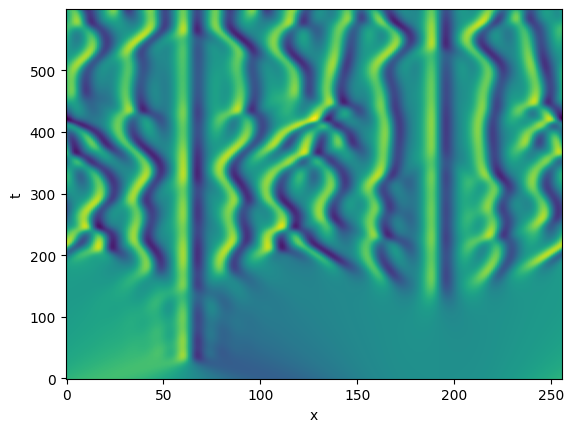

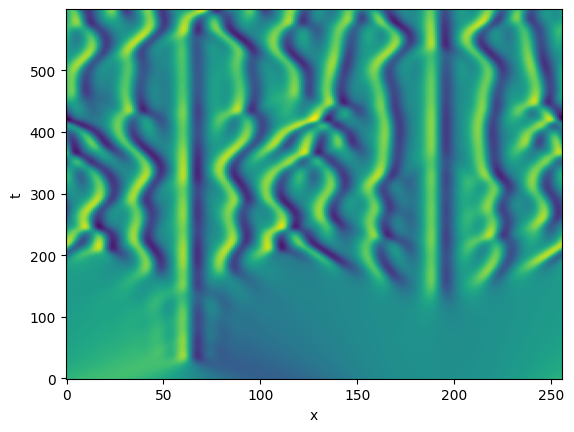

In [16]:
plt.imshow(all[:,0,:], aspect='auto',origin='lower')
plt.xlabel('x')
plt.ylabel('t')
plt.show()
plt.imshow(all_2[:,0,:], aspect='auto',origin='lower')
plt.xlabel('x')
plt.ylabel('t')
plt.show()